Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 30-October-2025

In [1]:
import pandas as pd
import numpy as np 
import itertools
import operator  # For fast sorting
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [2]:
# Set parameters 
data_dir = r'Z:/Data/Roadrunner/'
syn_thresh = 5

In [3]:
# Load connectivity 
df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections_princeton.csv')
df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")

# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurotransmitters.csv') # neuron.csv

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [4]:
# Set source neurons
dict_nodes = {}
dict_nodes['RR'] = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name=='Roadrunner'].tolist() 
dict_nodes['BPN'] = df_neurons_of_interest.root_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
    
source_nodes = list(itertools.chain(*list(dict_nodes.values())))

In [5]:
# Set ranks for sorting
class_rank = {}
class_rank['descending'] = 0
class_rank['central'] = 1
class_rank['motor'] = 2
class_rank['ascending'] = 3
class_rank['sensory'] = 4
class_rank['optic'] = 5
class_rank['visual_projection'] = 6
class_rank['visual_centrifugal'] = 7
class_rank['endocrine'] = 8

nt_rank = {}
nt_rank['ACH'] = 0
nt_rank['DA'] = 1
nt_rank['OCT'] = 2
nt_rank['SER'] = 3
nt_rank['GABA'] = 4
nt_rank['GLUT'] = 5

In [6]:
# Trim connectivity datatframe
df_connectivity = df_connectivity[df_connectivity['post_root_id'].isin(source_nodes)]

In [7]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [8]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]
df_connectivity

,pre_root_id,post_root_id,syn_count
7044,720575940639747235,720575940639781027,42
5739,720575940631092498,720575940651418102,34
932,720575940612667414,720575940639781027,31
2266,720575940619369688,720575940628859751,30
1875,720575940617716893,720575940628859751,30
...,...,...,...
6357,720575940633949613,720575940639781027,5
4220,720575940626067729,720575940633362145,5
5597,720575940630643275,720575940628859751,5
2837,720575940621395233,720575940630915791,5


In [9]:
# Get partner nodes
partner_nodes = df_connectivity['pre_root_id'].unique().tolist()

In [10]:
# Build network graph
net = nx.DiGraph() 

# Add nodes
net.add_nodes_from(source_nodes)
net.add_nodes_from(partner_nodes)

# Add edges
for index, _ in df_connectivity.iterrows(): 
    net.add_edge(df_connectivity["pre_root_id"][index], 
                 df_connectivity["post_root_id"][index], 
                 weight=int(df_connectivity.syn_count[index]))  

In [11]:
# Build connectivity matrix
conn_mat = np.zeros([len(source_nodes),len(partner_nodes)])
edge_attributes = nx.get_edge_attributes(net, "weight")
    
for pre_node, post_node, attr in net.edges(data=True):
    row = source_nodes.index(post_node)
    col = partner_nodes.index(pre_node)
    conn_mat[row,col] = edge_attributes[(pre_node, post_node)]

In [12]:
# Generate dict with attributes for sorting
dict_partner_nodes = {}
for partner_node in partner_nodes:
    dict_partner_nodes[partner_node] = {}
    dict_partner_nodes[partner_node]["syn_count"] = df_connectivity.syn_count[df_connectivity["pre_root_id"] == partner_node].sum()
    dict_partner_nodes[partner_node]["super_class"] = df_class.super_class[df_class.root_id == partner_node].item()
    dict_partner_nodes[partner_node]["nt_type"] = df_nt.nt_type[df_nt.root_id == partner_node].item()    
    dict_partner_nodes[partner_node]["class_rank"] = class_rank[df_class.super_class[df_class.root_id == partner_node].item()]
    if pd.isnull(dict_partner_nodes[partner_node]["nt_type"]):
        dict_partner_nodes[partner_node]["nt_rank"] = 6
    else:    
        dict_partner_nodes[partner_node]["nt_rank"] = nt_rank[df_nt.nt_type[df_nt.root_id == partner_node].item()]

    connecting_source_nodes = df_connectivity["post_root_id"][df_connectivity["pre_root_id"] == partner_node].tolist()
    any_RR = bool([node for node in connecting_source_nodes if node in dict_nodes['RR']])
    any_BPN = bool([node for node in connecting_source_nodes if node in dict_nodes['BPN']])
    if any_RR and not any_BPN:
        dict_partner_nodes[partner_node]["shared_rank"] = 0
    elif any_RR and any_BPN:
        dict_partner_nodes[partner_node]["shared_rank"] = 1
    elif any_BPN and not any_RR:
        dict_partner_nodes[partner_node]["shared_rank"] = 3

In [13]:
# Create list of tuples with relevant sorting information
sort_list = [(partner_node, dict_partner_nodes[partner_node]["class_rank"], 
              dict_partner_nodes[partner_node]["shared_rank"], 
              dict_partner_nodes[partner_node]["syn_count"]) for partner_node in partner_nodes]

# Sort nodes 
sorted_list = sorted(sort_list, key=operator.itemgetter(3), reverse=True) # syn_count
sorted_list = sorted(sorted_list, key=operator.itemgetter(2), reverse=False) # shared_rank
sorted_list = sorted(sorted_list, key=operator.itemgetter(1), reverse=False) # class_rank

In [14]:
# Sort partner nodes and columns of connectivity matrix
partner_nodes_sorted = [i[0] for i in sorted_list]

column_index_sorted = [partner_nodes.index(i) for i in partner_nodes_sorted]
conn_mat_sorted = conn_mat[:,column_index_sorted]

In [15]:
# Sum connectivity matrix per neuron type
conn_mat_sorted_summed = np.zeros((2,np.size(conn_mat_sorted,axis=1)))
conn_mat_sorted_summed[0][:] = np.sum(conn_mat_sorted[:len(dict_nodes['RR'])][:], axis=0)
conn_mat_sorted_summed[1][:] = np.sum(conn_mat_sorted[len(dict_nodes['RR']):][:], axis=0)

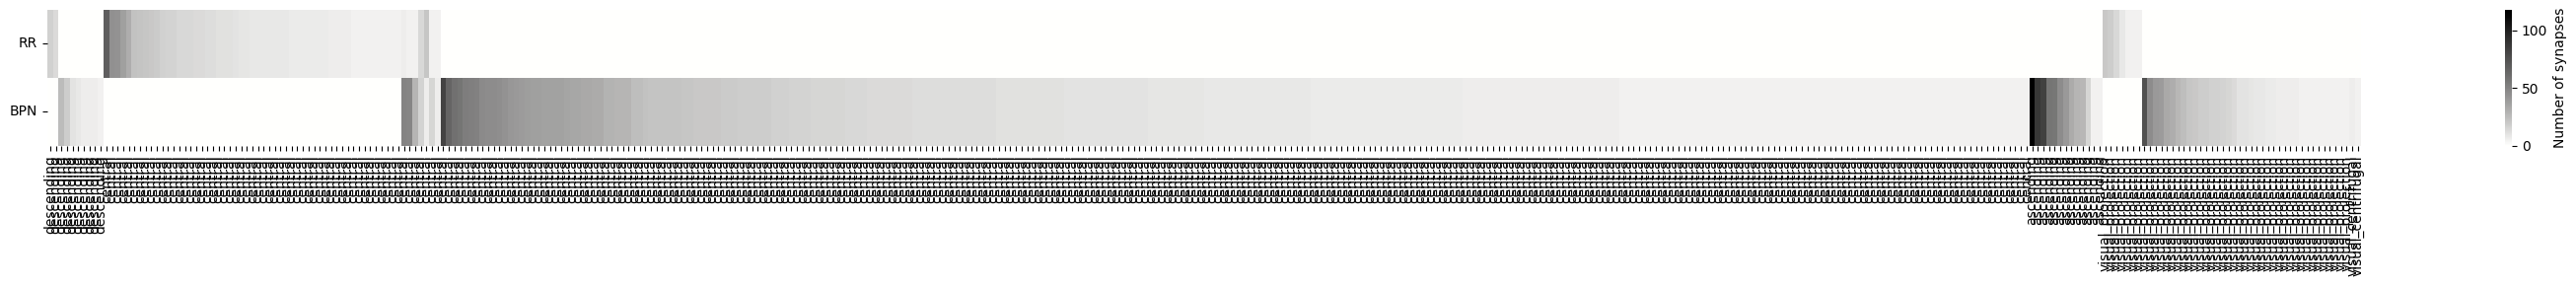

In [16]:
# Plot connectivity matrix 
fig = plt.figure(figsize=(30,3))
cmap = cmocean.cm.gray_r

xticklabels = []
for partner_node in partner_nodes_sorted:
    super_class = dict_partner_nodes[partner_node]['super_class']
    xticklabels.append(super_class)

yticklabels = list(dict_nodes.keys())
        
sns.heatmap(conn_mat_sorted_summed, 
            cmap = cmap, 
            xticklabels = xticklabels, 
            yticklabels = yticklabels,
            cbar_kws = {'label': 'Number of synapses'})
            
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

In [43]:
# Compute relative shared input

# Find indices of shared presynaptic neurons
indices_shared = []
for index, _ in enumerate(partner_nodes_sorted):
    if (conn_mat_sorted_summed[0,index] > 0) and (conn_mat_sorted_summed[1,index] > 0):
        indices_shared.append(index)

# Compute relative shared input onto RR
shared_input_RR = np.sum(conn_mat_sorted_summed[0][indices_shared]) / np.sum(conn_mat_sorted_summed[0])

# Compute relative shared input onto BPN
shared_input_BPN = np.sum(conn_mat_sorted_summed[1][indices_shared]) / np.sum(conn_mat_sorted_summed[1])

In [49]:
1-shared_input_BPN

np.float64(0.9670606471614028)

In [17]:
# Neuropil dictionary
dict_neuropils = {
        'LA': 'OL',
        'ME': 'OL',
        'AME': 'OL',
        'LO': 'OL',
        'LOP': 'OL',
        'MB': 'MB', 
        'MB_CA': 'MB',
        'MB_PED': 'MB',
        'SPU': 'MB',
        'MB_VL': 'MB',
        'MB_ML': 'MB',
        'FB': 'CX',
        'EB': 'CX',
        'PB': 'CX',
        'NO': 'CX',
        'BU': 'LX',
        'LAL': 'LX',
        'GA': 'LX',
        'AOTU': 'VLNP',
        'VLP': 'VLNP',
        'AVLP': 'VLNP',
        'PVLP': 'VLNP',
        'PLP': 'VLNP',
        'WED': 'VLNP',
        'LH': 'LH',
        'SLP': 'SNP',
        'SIP': 'SNP',
        'SMP': 'SNP',
        'CRE': 'INP',
        'CL': 'INP',
        'SCL': 'INP',
        'ICL': 'INP',
        'IB': 'INP',
        'ATL': 'INP',
        'AL': 'AL',
        'VX': 'VMNP',
        'VES': 'VMNP',
        'EPA': 'VMNP',
        'GOR': 'VMNP',
        'PS': 'VMNP',
        'SPS': 'VMNP',
        'IPS': 'VMNP',
        'AMMC': 'PENP',
        'SAD': 'PENP',
        'FLA': 'PENP',
        'CAN': 'PENP',
        'PRW': 'PENP',
        'GNG': 'GNG',
        'nan': 'UNASGD',
        'UNASGD': 'UNASGD'}

In [18]:
# Generate dataframe with relative synapse counts per neuropil for each presynaptic neuron 
df_neuropil = pd.DataFrame()

# Reload full conectivity
if syn_prediction == 'princeton':
    df_neuropil = pd.read_csv(data_dir + 'flywire_v783_connections_princeton.csv')
    df_neuropil = df_neuropil.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")
else:
    df_neuropil = pd.read_csv(data_dir + 'flywire_v783_connections.csv')

# Trim connectivity datatframe
df_neuropil = df_neuropil[df_neuropil['post_root_id'].isin(partner_nodes)]

# Remove connections between neurons smaller than syn_thresh 
df_neuropil_summed = df_neuropil.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_neuropil_summed = df_neuropil_summed[df_neuropil_summed.syn_count>=syn_thresh]
pre_root_ids_to_keep = df_neuropil_summed.pre_root_id.tolist()
post_root_ids_to_keep = df_neuropil_summed.post_root_id.tolist()

df_neuropil = df_neuropil[(df_neuropil.pre_root_id.isin(pre_root_ids_to_keep)) & (df_neuropil.pre_root_id.isin(post_root_ids_to_keep))]


# Generate list of neuropil names with _L and _R
neuropil_names_merged = df_neuropil.neuropil.to_list()
for ix, i in enumerate(neuropil_names_merged):
    if pd.isnull(i):
        neuropil_names_merged[ix] = 'UNASGD'
    elif '_' in i:
        neuropil_names_merged[ix] = i[:-(len(i)-i.find('_'))] 

# Replace neuropil names 
df_neuropil['neuropil'] = pd.Series(neuropil_names_merged).values
df_neuropil.reset_index(drop=True, inplace=True)

# Sum entries where neuropil is the same (merge synapse counts of left and right hemisphere) 
df_neuropil = df_neuropil.groupby(['post_root_id','neuropil'])['syn_count'].sum().reset_index()
df_neuropil = df_neuropil.rename(columns={"post_root_id": "root_id"}, errors="raise")


# Compute relative synapse counts
df_synapse_counts = df_neuropil.groupby(['root_id'])['syn_count'].sum().reset_index()

rel_syn_count = []
for _ , row in df_neuropil.iterrows():
    rel_syn_count.append(row.syn_count / (df_synapse_counts.syn_count[df_synapse_counts.root_id == row.root_id].item()))

df_neuropil["rel_syn_count"] = rel_syn_count

In [19]:
df_neuropil

,root_id,neuropil,syn_count,rel_syn_count
0,720575940603117996,ATL,4,0.088889
1,720575940603117996,PLP,5,0.111111
2,720575940603117996,SCL,11,0.244444
3,720575940603117996,SLP,7,0.155556
4,720575940603117996,SMP,18,0.400000
...,...,...,...,...
3175,720575940661321857,LH,1,0.038462
3176,720575940661321857,MB,1,0.038462
3177,720575940661321857,PLP,7,0.269231
3178,720575940661321857,SCL,9,0.346154


In [20]:
# Generate connectivity matrix with relative synapse counts from presynaptic neuropils
neuropils = list(dict_neuropils.keys())
conn_mat_neuropils = np.zeros([len(source_nodes),len(neuropils)])

for source_index, source_node in enumerate(source_nodes):
    df_connectivity_source = df_connectivity[df_connectivity.post_root_id == source_node] 

    for _ , source_row in df_connectivity_source.iterrows():
        df_neuropil_source = df_neuropil[df_neuropil.root_id == source_row.pre_root_id]

        for _ , neuropil_row in df_neuropil_source.iterrows():
            neuropil_index = neuropils.index(neuropil_row.neuropil)
    
            conn_mat_neuropils[source_index][neuropil_index] += source_row.syn_count*neuropil_row.rel_syn_count

In [52]:
# Sum and normalize connectivity matrix per neuron type
conn_mat_neuropils_summed = np.zeros((2,np.size(conn_mat_neuropils,axis=1)))
conn_mat_neuropils_summed[0][:] = np.sum(conn_mat_neuropils[:len(dict_nodes['RR'])][:], axis=0)
conn_mat_neuropils_summed[0][:] = conn_mat_neuropils_summed[0][:] / np.sum(conn_mat_neuropils_summed[0][:])
conn_mat_neuropils_summed[1][:] = np.sum(conn_mat_neuropils[len(dict_nodes['RR']):][:], axis=0)
conn_mat_neuropils_summed[1][:] = conn_mat_neuropils_summed[1][:] / np.sum(conn_mat_neuropils_summed[1][:])

In [53]:
# Exclude neuropils with value zero
columns_to_include = (np.sum(conn_mat_neuropils_summed,axis=0) > 0)
columns_to_include = [i for i, x in enumerate(columns_to_include) if x]

neuropils = [neuropil for index, neuropil in enumerate(neuropils) if index in columns_to_include]
conn_mat_neuropils_summed = conn_mat_neuropils_summed[:,columns_to_include]

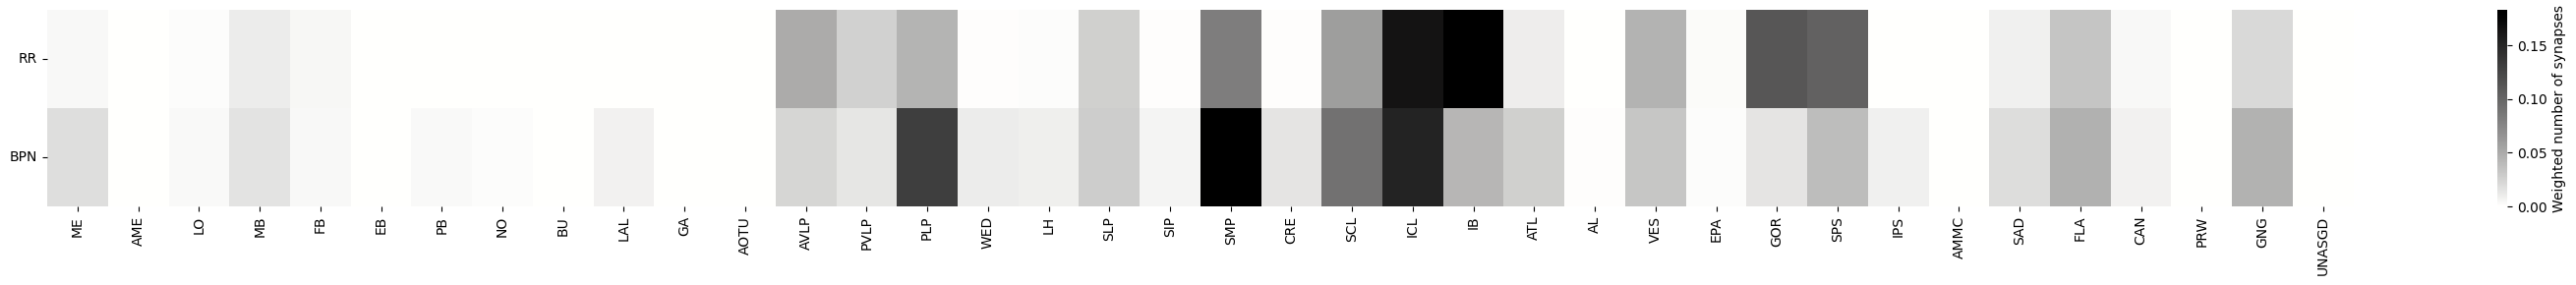

In [55]:
# Plot connectivity matrix 
fig = plt.figure(figsize=(30,3))
cmap = cmocean.cm.gray_r

xticklabels = neuropils
yticklabels = list(dict_nodes.keys())
        
sns.heatmap(conn_mat_neuropils_summed, 
            cmap = cmap, 
            xticklabels = xticklabels, 
            yticklabels = yticklabels,
            cbar_kws = {'label': 'Weighted number of synapses'})
            
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig.tight_layout()
#plt.savefig('C:/Users/Chris/Desktop/figure.pdf')
plt.show()